In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm.notebook import tqdm

seed = 42

**Link to great advanced inpainting models**

* [lama](https://github.com/saic-mdal/lama)
* [nipponjo](https://github.com/nipponjo/deepfillv2-pytorch)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
epochs = 40
batch_size = 16
lr = 8e-5
image_size = 128
path = r'painting_model.pth'
b1 = 0.5
b2 = 0.999

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
image_paths = sorted([str(p) for p in glob('../input/celebahq-resized-256x256/celeba_hq_256' + '/*.jpg')])

train, valid = train_test_split(image_paths, test_size=5000, shuffle=True, random_state=seed)
valid, test = train_test_split(valid, test_size=1000, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, validation size: {len(valid)}, test size: {len(test)}.')

Train size: 25000, validation size: 4000, test size: 1000.


In [5]:
h_margin = w_margin = 8
box_height = 35
box_width = 30
delta_h = delta_w = 5
height = width = 128

def brush_stroke_mask(shapes=(height, width)):

    min_num_vertex = 4
    max_num_vertex = 12
    min_width = 12
    max_width = 40

    mean_angle = 2 * np.pi / 5
    angle_range = 2 * np.pi / 15

    H, W = shapes

    average_radius = np.sqrt(H**2 + W**2) / 8
    mask = Image.new('L', (W, H), 0)

    for _ in range(np.random.randint(1, 4)):
        num_vertex = np.random.randint(min_num_vertex, max_num_vertex)
        angle_min = mean_angle - np.random.uniform(0, angle_range)
        angle_max = mean_angle + np.random.uniform(0, angle_range)
        angles = []
        vertex = []
        for i in range(num_vertex):
            if i % 2 == 0:
                angles.append(2 * np.pi - np.random.uniform(angle_min, angle_max))
            else:
                angles.append(np.random.uniform(angle_min, angle_max))

        h, w = mask.size
        vertex.append((int(np.random.randint(0, w)), int(np.random.randint(0, h))))

        for i in range(num_vertex):
            r = np.clip(
                np.random.normal(loc=average_radius, scale=average_radius//2),
                0, 2*average_radius)
            new_x = np.clip(vertex[-1][0] + r * np.cos(angles[i]), 0, w)
            new_y = np.clip(vertex[-1][1] + r * np.sin(angles[i]), 0, h)
            vertex.append((int(new_x), int(new_y)))

        draw = ImageDraw.Draw(mask)
        width = int(np.random.uniform(min_width, max_width))
        draw.line(vertex, fill=1, width=width)
        for v in vertex:
            draw.ellipse((v[0] - width//2, v[1] - width//2,
                          v[0] + width//2, v[1] + width//2),
                         fill=1)

    if np.random.normal() > 0:
        mask.transpose(Image.FLIP_LEFT_RIGHT)
    if np.random.normal() > 0:
        mask.transpose(Image.FLIP_TOP_BOTTOM)
    mask = np.asarray(mask, np.float32)
    mask = np.reshape(mask, (1, 1, H, W))
    
    return torch.Tensor(mask)

def random_bbox(shapes=(height, width), margins=(h_margin, w_margin), box_shapes=(box_height, box_width)):

    img_height, img_width = shapes
    vertical_margin, horizontal_margin = margins
    b_height, b_width = box_shapes

    maxt = img_height - vertical_margin - b_height
    maxl = img_width - horizontal_margin - b_width
    t = np.random.randint(vertical_margin, maxt)
    l = np.random.randint(horizontal_margin, maxl)

    return (t, l, b_height, b_width)

def bbox2mask(bbox, shapes=(height, width), delta_shapes=(delta_h, delta_w)):
    img_height, img_width = shapes
    max_delta_height, max_delta_width = delta_shapes
    mask = torch.zeros((1, 1, img_height, img_width), dtype=torch.float32)

    h = np.random.randint(max_delta_height // 2 + 1)
    w = np.random.randint(max_delta_width // 2 + 1)
    mask[:, :, bbox[0]+h: bbox[0]+bbox[2]-h, bbox[1]+w: bbox[1]+bbox[3]-w] = 1.
    
    return mask

In [6]:
class CelebaDataset(Dataset):
    def __init__(self, images_paths):
        self.images_paths = images_paths
        self.train = train
        
    def __len__(self):
        return len(self.images_paths)
      
    def get_random_brush(self):
        irr_mask = brush_stroke_mask()
        bbox = random_bbox()
        reg_mask = bbox2mask(bbox)
        mask = torch.logical_or(reg_mask, irr_mask).to(torch.float32)
        
        return mask
        
    def __getitem__(self, ix):
        path = self.images_paths[ix]
        
        image = Image.open(path).resize((width, height), Image.NEAREST)
        image = np.array(image).transpose(2,0,1)[np.newaxis, ...]
        image = torch.as_tensor(image, dtype=torch.float32)
        
        mask = self.get_random_brush()
        image = image / 255.
        masked_image = image * (1 - mask)
        
        return image, masked_image
    
    def collate_fn(self, batch):
        images, masked_images = list(zip(*batch))
        images, masked_images = [[tensor.to(device) for tensor in ims] for ims in [images, masked_images]]
        images, masked_images = [torch.cat(ims) for ims in [images, masked_images]]
        return images, masked_images

In [7]:
train_dataset = CelebaDataset(train)
valid_dataset = CelebaDataset(valid)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [8]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1, 0.02)
        nn.init.zeros_(m.bias)
        
def set_params(model, unfreeze):
    for param in model.parameters():
        param.requires_grad = unfreeze

In [9]:
!pip install -qq torchsummary
from torchsummary import summary

In [10]:
class KLDLoss(nn.Module):
    def forward(self, mu, logvar, beta=1.0):  # beta = 0.1
        kld = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
        return beta * kld  

# reconstruction_loss = nn.functional.binary_cross_entropy_with_logits
reconstruction_loss = nn.functional.mse_loss  # see https://stats.stackexchange.com/questions/409377/why-is-vae-reconstruction-loss-equal-to-mse-loss

kld_loss = KLDLoss()

kld_criterion = lambda x, y, mu, logvar: reconstruction_loss(y, x, reduction="sum") + kld_loss(mu, logvar, beta=0.1)  # reduction sum here + weigth for kld_loss

**Fully convolutional generator**

In [11]:
class ResDown(nn.Module):

    def __init__(self, channel_in, channel_out, scale=2):
        super(ResDown, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(channel_out//2, 0.8)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, scale, 1)
        self.batch_norm2 = nn.BatchNorm2d(channel_out, 0.8)
        
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, scale, 1)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        skip = self.conv3(x)
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x + skip)
        
        return x
    
class ResUp(nn.Module):
    
    def __init__(self, channel_in, channel_out, scale=2):
        super(ResUp, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(channel_out//2, 0.8)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(channel_out, 0.8)
        
        self.upscale = nn.Upsample(scale_factor=scale, mode="nearest")
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)
        
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        skip = self.conv3(self.upscale(x))
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)

        x = self.conv2(self.upscale(x))
        x = self.batch_norm2(x)

        x = self.activation(x + skip)
        
        return x

In [12]:
class Encoder(nn.Module):

    def __init__(self, channels, ch=64, z=512):
        super(Encoder, self).__init__()
        self.conv1 = ResDown(channels, ch)  
        self.conv2 = ResDown(ch, 2*ch)  
        self.conv3 = ResDown(2*ch, 4*ch)  
        self.conv4 = ResDown(4*ch, 8*ch) 
        self.conv5 = ResDown(8*ch, 8*ch)  
        self.conv_mu = nn.Conv2d(8*ch, z, 2, 2) 
        self.conv_log_var = nn.Conv2d(8*ch, z, 2, 2) 

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        mu = self.conv_mu(x)
        log_var = self.conv_log_var(x)
        x = self.sample(mu, log_var)

        return x, mu, log_var
    
class Decoder(nn.Module):

    def __init__(self, channels, ch=64, z=512):
        super(Decoder, self).__init__()
        self.conv1 = ResUp(z, ch*8)
        self.conv2 = ResUp(ch*8, ch*4)
        self.conv3 = ResUp(ch*4, ch*2)
        self.conv4 = ResUp(ch*2, ch)
        self.conv5 = ResUp(ch, ch//2)
        self.conv6 = ResUp(ch//2, ch)
        self.conv7 = nn.Conv2d(ch, channels, 3, 1, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        return self.activation(x) 

In [13]:
# originally mask has to be concatenated with gt image

class ResnetGenerator(nn.Module):
    
    def __init__(self, channel_in=3, ch=64, z=512):
        super(ResnetGenerator, self).__init__()
        
        self.encoder = Encoder(channel_in, ch=ch, z=z)
        self.decoder = Decoder(channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding, mu, log_var = self.encoder(x)
        recon = self.decoder(encoding)
        return recon, mu, log_var

In [14]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize, dropout, spectral):
            """Returns layers of each discriminator block"""
            if spectral:
                layers = [nn.utils.spectral_norm(nn.Conv2d(in_filters, out_filters, 3, stride, 1), n_power_iterations=2)]
            else:
                layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                layers.append(nn.Dropout(p=0.5))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize, dropout, spectral in [(64, 2, False, 0, 0), (128, 2, True, 0, 0), (256, 2, True, 0, 0), (512, 1, True, 0, 0)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize, dropout, spectral))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [15]:
generator = ResnetGenerator().apply(init_weights).to(device)
discriminator = Discriminator().apply(init_weights).to(device)

In [16]:
summary(generator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2         [-1, 32, 128, 128]             896
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         LeakyReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
           ResDown-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10           [-1, 64, 64, 64]          36,928
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        LeakyReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

In [17]:
summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]          73,856
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         295,168
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 512, 16, 16]       1,180,160
   InstanceNorm2d-10          [-1, 512, 16, 16]               0
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 1, 16, 16]           4,609
Total params: 1,555,585
Trainable params: 1,555,585
Non-trainable params: 0
---------------------------

In [18]:
adversarial_loss = nn.MSELoss()  # instead of bce loss
# pixelwise_loss = nn.L1Loss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))  # AdamW weight_decay=1e-3, eps=1e-2
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [19]:
def train_one_batch(batch, generator, discriminator, criterion_adv, criterion_pix, optimizer_G, optimizer_D):
    generator.train()
    discriminator.train()
    
    images, masked_images = batch
    real = torch.ones(batch_size, *[1, 16,16], dtype=torch.float32).requires_grad_(False).to(device)
    fake = torch.zeros(batch_size, *[1, 16,16], dtype=torch.float32).requires_grad_(False).to(device)
    
    set_params(discriminator, False)
    optimizer_G.zero_grad()
    gen_parts, mu, logvar = generator(masked_images)
    
    gan_loss = criterion_adv(discriminator(gen_parts), real)
    pix_loss = criterion_pix(masked_images, gen_parts, mu, logvar)
    
    loss_g = 0.001 * gan_loss + 0.999 * pix_loss
    loss_g.backward()
    optimizer_G.step()
    
    set_params(discriminator, True)
    optimizer_D.zero_grad()

    real_loss = criterion_adv(discriminator(masked_images), real)
    fake_loss = criterion_adv(discriminator(gen_parts.detach()), fake)
    
    loss_d = (real_loss + fake_loss) / 2
    loss_d.backward()
    optimizer_D.step()
    
    return loss_g.item(), loss_d.item()

@torch.no_grad()
def validate_one_batch(batch, generator, discriminator, criterion_adv, criterion_pix):
    generator.eval()
    discriminator.eval()
    
    images, masked_images = batch
    real = torch.ones(batch_size, *[1, 16,16], dtype=torch.float32).requires_grad_(False).to(device)
    fake = torch.zeros(batch_size, *[1, 16,16], dtype=torch.float32).requires_grad_(False).to(device)
    
    gen_parts, mu, logvar = generator(masked_images)
    
    gan_loss = criterion_adv(discriminator(gen_parts), real)  # smooth 0.1 for logloss?
    pix_loss = criterion_pix(masked_images, gen_parts, mu, logvar)
    
    loss_g = 0.001 * gan_loss + 0.999 * pix_loss
    
    real_loss = criterion_adv(discriminator(masked_images), real)
    fake_loss = criterion_adv(discriminator(gen_parts.detach()), fake)
    
    loss_d = (real_loss + fake_loss) / 2
    
    return loss_g.item(), loss_d.item()

@torch.no_grad()
def test_plot(test, generator, scale=1):
    idx = np.random.randint(len(test))
    random_path = test[idx]
    
    image = Image.open(random_path).resize((width, height), Image.NEAREST)
    image = np.array(image).transpose(2,0,1)[np.newaxis, ...]
    image = torch.as_tensor(image, dtype=torch.float32)

    mask = train_dataset.get_random_brush()
    image = image / 255.
    masked_image = image * (1 - mask)

    generator.eval()
    gen_part = generator(masked_image.to(device))[0].squeeze(0).cpu().detach()

    image = T.ToPILImage()(image[0])
    masked_image = T.ToPILImage()(masked_image[0])
    gen_part = T.ToPILImage()(gen_part[0])
    
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis("off")
    
    plt.subplot(132)
    plt.title('Masked Image')
    plt.imshow(masked_image)
    plt.axis("off")
    
    plt.subplot(133)
    plt.title('Inpainted Image')
    plt.imshow(gen_part)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

Epoch 1/40


Train step 1:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 1:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/40


Train step 2:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 2:   0%|          | 0/250 [00:00<?, ?it/s]

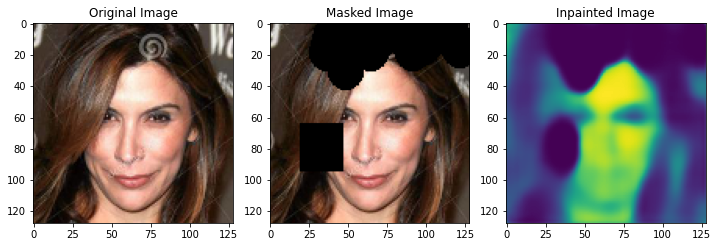

Epoch 3/40


Train step 3:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 3:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/40


Train step 4:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 4:   0%|          | 0/250 [00:00<?, ?it/s]

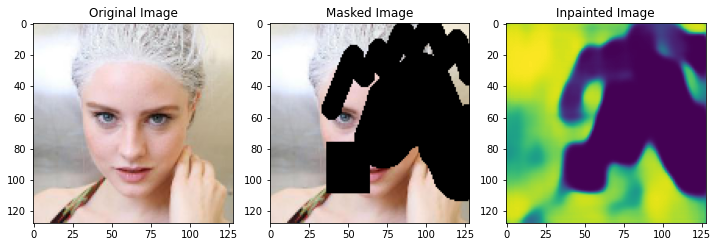

Epoch 5/40


Train step 5:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 5:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/40


Train step 6:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 6:   0%|          | 0/250 [00:00<?, ?it/s]

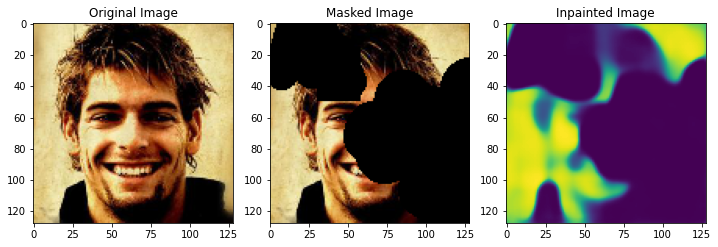

Epoch 7/40


Train step 7:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 7:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/40


Train step 8:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 8:   0%|          | 0/250 [00:00<?, ?it/s]

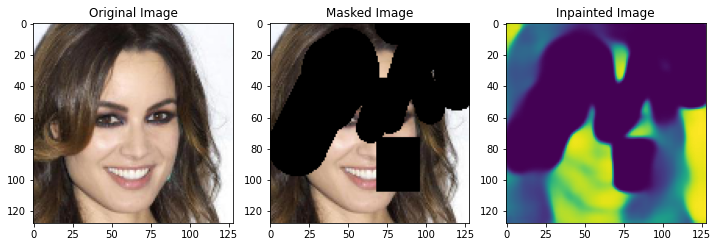

Epoch 9/40


Train step 9:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 9:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/40


Train step 10:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 10:   0%|          | 0/250 [00:00<?, ?it/s]

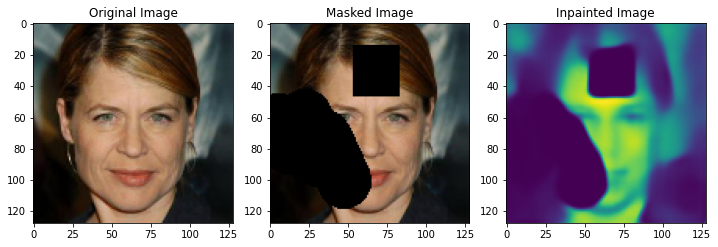

Epoch 11/40


Train step 11:   0%|          | 0/1562 [00:00<?, ?it/s]

Validation step 11:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/40


Train step 12:   0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
train_d_losses, valid_d_losses = [], []
train_g_losses, valid_g_losses = [], []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    tq_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Train step {epoch+1}')
    epoch_d_losses, epoch_g_losses = [], []
    for _, batch in enumerate(tq_bar):
        g_loss, d_loss = train_one_batch(batch, generator, discriminator, adversarial_loss, 
                                         kld_criterion, optimizer_G, optimizer_D)
        epoch_g_losses.append(g_loss)
        epoch_d_losses.append(d_loss)
        tq_bar.set_postfix(g_loss=np.mean(epoch_g_losses), d_loss=np.mean(epoch_d_losses))
    train_d_losses.append(np.mean(epoch_d_losses))
    train_g_losses.append(np.mean(epoch_g_losses))
    
    tq_bar = tqdm(valid_dataloader, total=len(valid_dataloader), desc=f'Validation step {epoch+1}')
    epoch_d_losses, epoch_g_losses = [], []
    for _, batch in enumerate(tq_bar):
        g_loss, d_loss = validate_one_batch(batch, generator, discriminator, adversarial_loss, kld_criterion)
        epoch_d_losses.append(d_loss)
        epoch_g_losses.append(g_loss)
        tq_bar.set_postfix(g_loss=np.mean(epoch_g_losses), d_loss=np.mean(epoch_d_losses))
    valid_d_losses.append(np.mean(epoch_d_losses))
    valid_g_losses.append(np.mean(epoch_g_losses))
    
    if (epoch+1) % 2 == 0 or (epoch+1) == epochs:
        test_plot(test, generator)
        checkpoint = {
            'discriminator': discriminator,
            'generator': generator,
        }
        torch.save(checkpoint, path)
        
plt.figure(figsize=(8, 4))
x_axis = np.arange(1,epochs+1)
plt.subplot(121)
plt.title('Discriminator train/valid losses')
plt.plot(x_axis, train_d_losses, label='train d_loss')
plt.plot(x_axis, valid_d_losses, label='valid d_loss')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('Genrator train/valid losses')
plt.plot(x_axis, train_g_losses, label='train g_loss')
plt.plot(x_axis, valid_g_losses, label='valid_g_loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

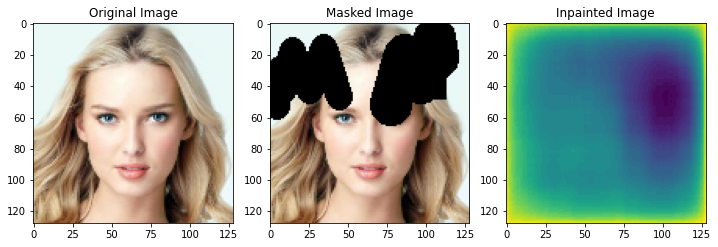

In [114]:
test_plot(test, generator)

#### [Kernel outputs visualization V1 vanilla CNN AE.](https://www.kaggle.com/code/pankratozzi/pytorch-vaegan-face-inpainting?scriptVersionId=102242524)
#### [Kernel ouputs visualization V2 - CNN VAE with reparametrization](https://www.kaggle.com/code/pankratozzi/pytorch-vaegan-face-inpainting?scriptVersionId=110137217)